In [12]:
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt

from sciterra.mapping.atlas import Atlas
from sciterra.mapping.cartography import Cartographer
from sciterra.vectorization.scibert import SciBERTVectorizer
from sciterra.vectorization.bow import BOWVectorizer

In [2]:
# atlas_dir = "/Users/nathanielimel/uci/projects/sciterra/src/examples/scratch/outputs/atlas_s2-11-10-23_centered_hafenetal"
# atlas_dir = "/Users/nathanielimel/uci/projects/sciterra/src/examples/scratch/outputs/atlas_s2-11-10-23-sbert_centered_hafenetal"
# atlas_dir = "/Users/nathanielimel/uci/projects/sciterra/src/examples/scratch/outputs/atlas_s2-11-11-23_w2v-centered_hafenetal"
# atlas_dir = "outputs/atlas_s2-11-11-23_bow-centered_hafenetal"
atlas_dir = "outputs/default_atlas_dir"

In [3]:
atl = Atlas.load(atlas_dir)

No center to read, skipping.


In [4]:
atl.history.keys()

dict_keys(['pubs_per_update', 'kernel_size'])

In [5]:
kernels = atl.history['kernel_size']
kernels.shape

(10098, 19)

In [6]:
convergence_degrees = list(range(kernels.shape[1])) # the max convergence iteration
# adding 1 because '0' con_d is weird, does not follow the monotonically decreasing relationship of pubs w conv degree


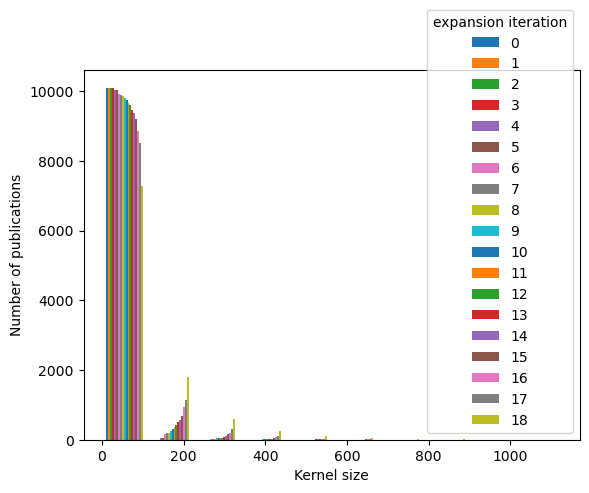

In [7]:
# plt.hist(x=kernels)

plt.hist(kernels, label=range(kernels.shape[1]))
 
plt.xlabel('Kernel size')
plt.ylabel('Number of publications')
plt.legend(
    title = 'expansion iteration',
)
plt.show()

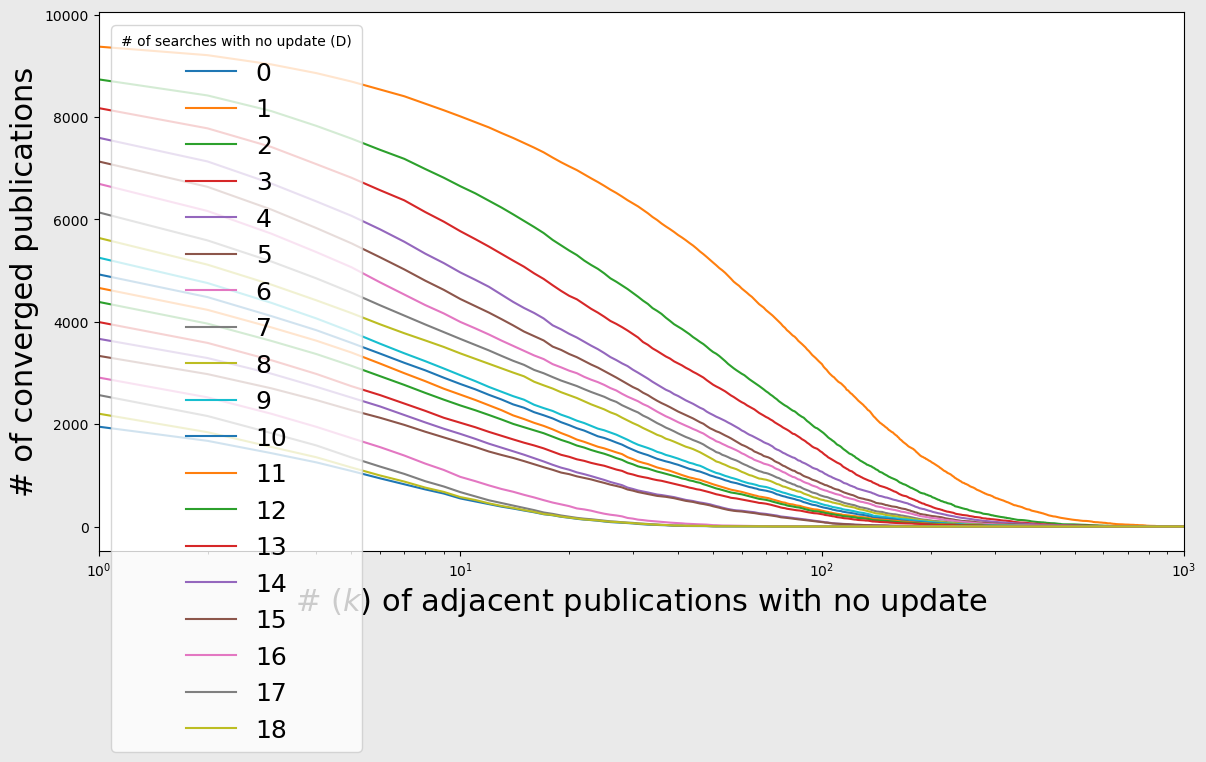

In [8]:
fig = plt.figure( figsize=(14,7), facecolor=np.array([ 235, 235, 235 ]) / 256. )
ax = plt.gca()

n_total = 0
n_all = 0
n_samples = []

bins = np.arange( -0.5, kernels.max()+1.5, 1. )

for i, con_d in enumerate( convergence_degrees ):

    # Calculate the distribution of kernel sizes
    hist, bins = np.histogram(
        kernels[:,-con_d], # the largest kernel size that hasn't changed since the 3rd to last update, i.e. after 7 updates
        bins = bins,
    )
    centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

    # Calculate the number of publications with that kernel size or more
    cumulative = np.cumsum( hist )
    reverse_cumulative = ( cumulative[-1] - cumulative )
    
    ax.plot(
        centers,
        reverse_cumulative,
        label = con_d,
    )

ax.set_xlim( 1, 1e3, )
# ax.set_ylim( 0, 15000 )
ax.set_xscale( 'log' )

ax.set_xlabel( r'# $(k)$ of adjacent publications with no update', fontsize=22 )
ax.set_ylabel( '# of converged publications', fontsize=22 )
ax.legend(
    prop={'size':18 },
    title = '# of searches with no update (D)',
)

# # Save
# save_fp = 'converged_kernel_size.pdf'
# fig.savefig( save_fp, bbox_inches='tight' )
# print( 'Saved at {}'.format( save_fp ) )

## Filter atlas by converged publications

In [231]:
# converged_kernel_size = data_k['converged_kernel_size'][:,-pm['convergence_degree']]
# converged = converged_kernel_size >= pm['kernel_size']
# publications = c.publications[converged]
# inds = np.arange( c.publications.size )[converged]

In [9]:
con_d = 5
kernel_size = 16
converged_filter = kernels[:, -con_d] >= kernel_size
ids = np.array(atl.projection.index_to_identifier)
converged_pub_ids = ids[converged_filter]

[atl[id].title for id in converged_pub_ids][:10]

['Low-redshift Lyman limit systems as diagnostics of cosmological inflows and outflows',
 'A BUDGET AND ACCOUNTING OF METALS AT z ∼ 0: RESULTS FROM THE COS-HALOS SURVEY',
 'CONFRONTING SIMULATIONS OF OPTICALLY THICK GAS IN MASSIVE HALOS WITH OBSERVATIONS AT z = 2–3',
 'Circum galactic medium emission : from modeling to detection by a dedicated UV space mission',
 'Properties of the circumgalactic medium in cosmic ray-dominated galaxy haloes',
 'An energy‐conserving formalism for adaptive gravitational force softening in smoothed particle hydrodynamics and N‐body codes',
 'A new class of accurate, mesh-free hydrodynamic simulation methods',
 'Cosmic ray feedback in the FIRE simulations: constraining cosmic ray propagation with GeV γ-ray emission',
 'The impact of different physical processes on the statistics of Lyman-limit and damped Lyman α absorbers',
 'The impact of baryonic physics on the structure of dark matter haloes: the view from the FIRE cosmological simulations']

### measure topography of converged pubs


In [14]:
# crt = Cartographer(vectorizer=SciBERTVectorizer())
crt = Cartographer(vectorizer=BOWVectorizer(model_path="outputs/atlas_s2-11-11-23_w2v-centered_hafenetal/astro_1.model"))

Loading saved Word2Vec model from outputs/atlas_s2-11-11-23_w2v-centered_hafenetal/astro_1.model.
Saving Word2Vec model at outputs/atlas_s2-11-11-23_w2v-centered_hafenetal/astro_1.model.


In [15]:
measurements = crt.measure_topography(
    atl, 
    ids=converged_pub_ids,
    metrics=["density", "edginess"], 
    kernel_size=kernel_size,
)

computing cosine similarity for 3810 embeddings with batch size 1000.


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
invalid value encountered in divide


Computing ['density', 'edginess'] for 3810 publications.


In [16]:
# get citations
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in converged_pub_ids
]
# what if we just drop all those with 0 citations (per year)?
# and those > 100 anyway
# citations_per_year = [item if (item > 0. and item < 100.) else None for item in citations_per_year ]
citations_per_year

[8.857142857142858,
 20.8,
 6.0,
 0.0,
 14.25,
 15.117647058823529,
 65.77777777777777,
 10.8,
 3.6,
 29.125,
 5.357142857142857,
 2.1666666666666665,
 5.0,
 28.392857142857142,
 6.285714285714286,
 18.2,
 17.4,
 16.8,
 27.647058823529413,
 27.842105263157894,
 1.6666666666666667,
 21.384615384615383,
 27.5,
 20.5,
 3.75,
 49.125,
 3.6666666666666665,
 2.0,
 7.538461538461538,
 9.2,
 7.666666666666667,
 2.111111111111111,
 2.6,
 131.47368421052633,
 5.25,
 93.2,
 1.0,
 2.3333333333333335,
 14.25,
 11.428571428571429,
 5.166666666666667,
 6.583333333333333,
 2.6923076923076925,
 13.333333333333334,
 11.5,
 5.0,
 29.545454545454547,
 57.84615384615385,
 5.5,
 21.357142857142858,
 2.7,
 15.5,
 11.692307692307692,
 4.363636363636363,
 28.571428571428573,
 2.0588235294117645,
 3.3333333333333335,
 30.25,
 10.833333333333334,
 7.857142857142857,
 17.0,
 4.0,
 1.25,
 0.0,
 63.61538461538461,
 22.17391304347826,
 4.125,
 12.181818181818182,
 10.285714285714286,
 5.2,
 12.428571428571429,
 14.3

In [17]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year
df.dropna(inplace=True) # not sure why this didn't take care of later NaNs
df.to_csv("stuff.csv")

In [18]:
# we expect the citation dist to have a long tail; most pubs are not cited at all, or have very few cites, while a handful of publications are extremely heavily cited

df_f = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= 100.)]

(
    pn.ggplot(
        # df,
        df_f,
        mapping=pn.aes(x="citations_per_year")
    )
    + pn.geom_histogram(bins=50)
    + pn.scale_x_log10()
    + pn.xlab("Citations per year")
    + pn.ylab(f"Count, total={len(df_f)}")
    + pn.theme(
        axis_title=pn.element_text(size=18)
    )
).save("poster_distribution.png", width=6, height=6, dpi=300,)

Saving 6 x 6 in image.
Filename: poster_distribution.png


In [32]:
# How many points are N cpy and below?
N = 25
cpy = df["citations_per_year"]
print(f"{len(cpy[cpy <= N])}/{len(cpy)} = ({len(cpy[cpy <= N]) / len(cpy) * 100} %) of publications received <= {N} cpy")

3543/3789 = (93.50752177355503 %) of publications received <= 25 cpy


In [33]:
# How many points are M density and below
M = 15
rho = df["density"]
print(f"{len(rho[rho <= N])}/{len(rho)} = ({len(rho[rho <= M]) / len(rho) * 100} %) of publications have <= {M} density")

3789/3789 = (97.09685932963843 %) of publications have <= 15 density


In [38]:
df_filtered = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= N)]
df_filtered = df_filtered[df_filtered["density"] <= M]

In [39]:
(
    pn.ggplot(
        df_filtered,
        mapping=pn.aes(
            x="density", 
            # x="edginess",
            y="citations_per_year",
        )
    )
    + pn.geom_point(
        alpha=0.2,
    )
    + pn.xlab("Density")
    # + pn.xlab("Asymmetry")
    + pn.ylab("Citations per year")
    + pn.geom_smooth(color="orange", size=2)
    + pn.theme(
        # axis_title_y=pn.element_blank(),
        axis_title=pn.element_text(size=18),
    )
).save("poster_supplementary.png", width=6, height=6, dpi=300,)

Saving 6 x 6 in image.
Filename: poster_supplementary.png
